In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import missingno as msno

In [2]:
rawtrainDF = pd.read_csv('NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
rawtestDF = pd.read_csv('NIJ_s_Recidivism_Challenge_Test_Dataset1.csv')

In [3]:
list(rawtrainDF.columns)

['ID',
 'Gender',
 'Race',
 'Age_at_Release',
 'Residence_PUMA',
 'Gang_Affiliated',
 'Supervision_Risk_Score_First',
 'Supervision_Level_First',
 'Education_Level',
 'Dependents',
 'Prison_Offense',
 'Prison_Years',
 'Prior_Arrest_Episodes_Felony',
 'Prior_Arrest_Episodes_Misd',
 'Prior_Arrest_Episodes_Violent',
 'Prior_Arrest_Episodes_Property',
 'Prior_Arrest_Episodes_Drug',
 '_v1',
 'Prior_Arrest_Episodes_DVCharges',
 'Prior_Arrest_Episodes_GunCharges',
 'Prior_Conviction_Episodes_Felony',
 'Prior_Conviction_Episodes_Misd',
 'Prior_Conviction_Episodes_Viol',
 'Prior_Conviction_Episodes_Prop',
 'Prior_Conviction_Episodes_Drug',
 '_v2',
 '_v3',
 '_v4',
 'Prior_Revocations_Parole',
 'Prior_Revocations_Probation',
 'Condition_MH_SA',
 'Condition_Cog_Ed',
 'Condition_Other',
 'Violations_ElectronicMonitoring',
 'Violations_Instruction',
 'Violations_FailToReport',
 'Violations_MoveWithoutPermission',
 'Delinquency_Reports',
 'Program_Attendances',
 'Program_UnexcusedAbsences',
 'Residen

In [4]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
df_train_missing = missing_values_table(rawtrainDF)

Your selected dataframe has 53 columns.
There are 11 columns that have missing values.


In [6]:
df_train_missing

,Missing Values,% of Total Values
Avg_Days_per_DrugTest,4260,23.6
DrugTests_THC_Positive,3632,20.1
DrugTests_Cocaine_Positive,3632,20.1
DrugTests_Meth_Positive,3632,20.1
DrugTests_Other_Positive,3632,20.1
Prison_Offense,2321,12.9
Gang_Affiliated,2217,12.3
Supervision_Level_First,1212,6.7
Jobs_Per_Year,534,3.0
Supervision_Risk_Score_First,330,1.8


<AxesSubplot:>

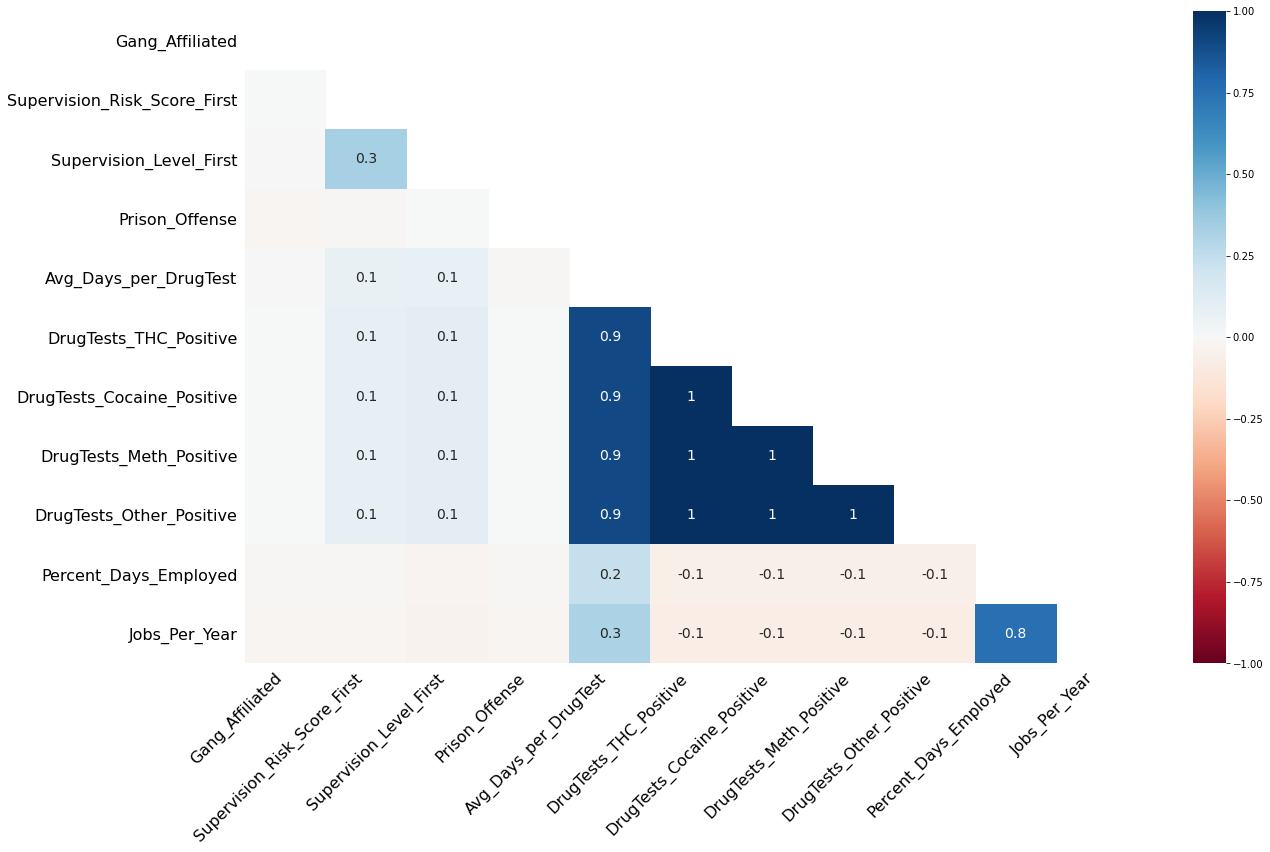

In [78]:
msno.heatmap(rawtrainDF)

<AxesSubplot:>

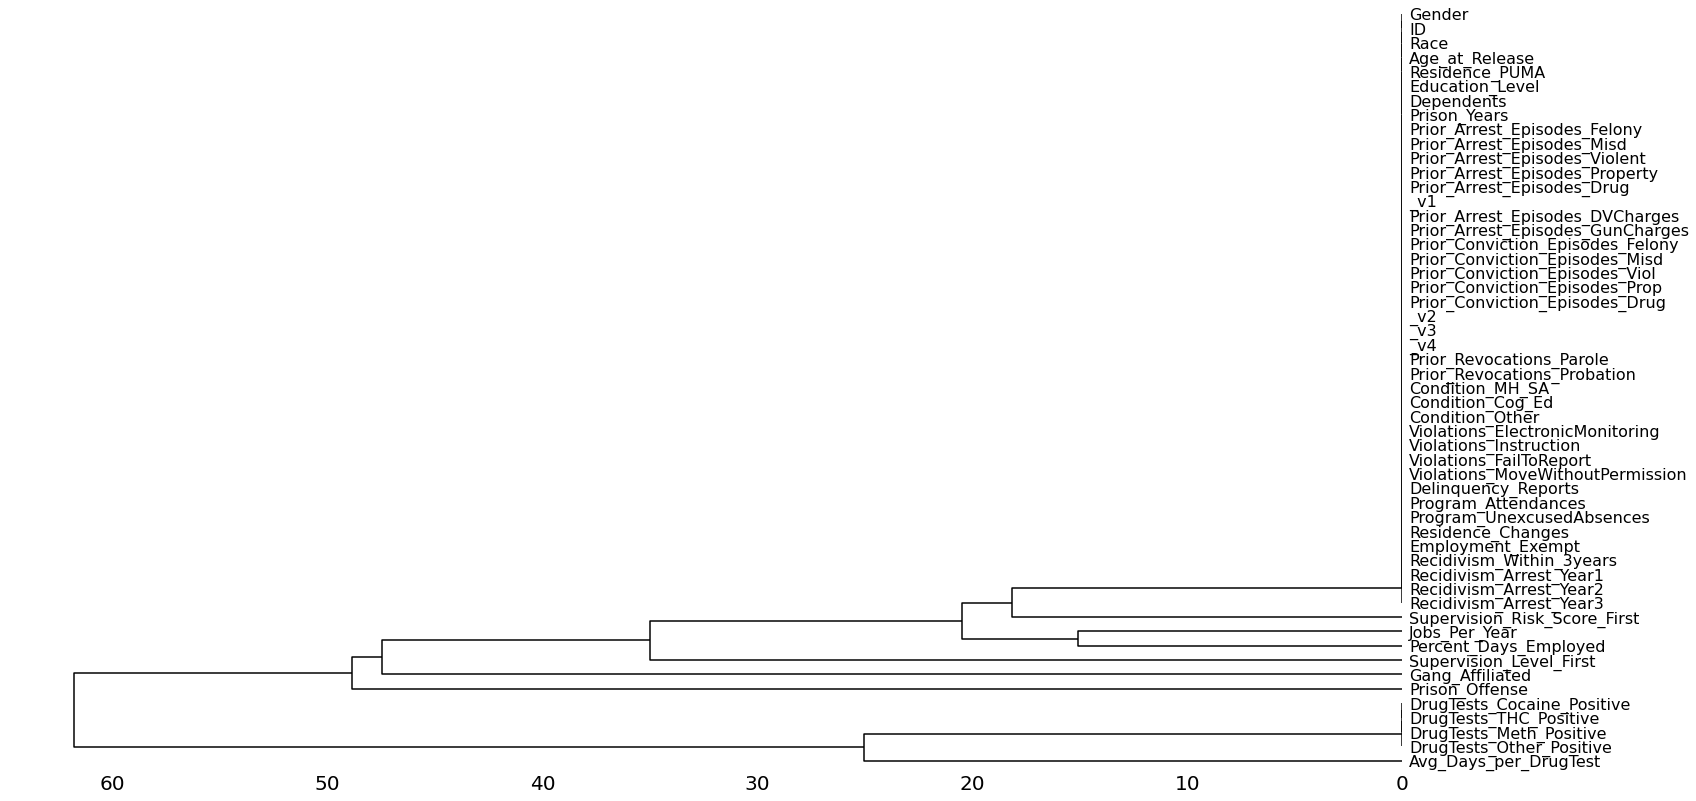

In [79]:
msno.dendrogram(rawtrainDF)

In [50]:
dfdrop = rawtrainDF.copy()
dfdrop = dfdrop.drop(['Avg_Days_per_DrugTest', 'DrugTests_THC_Positive', 'DrugTests_Cocaine_Positive', 
                      'DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 'Violations_ElectronicMonitoring', 
                      'Violations_Instruction', 'Violations_FailToReport', 'Violations_MoveWithoutPermission', 
                      'Delinquency_Reports', 'Program_Attendances', 'Program_UnexcusedAbsences', 'Residence_Changes', 
                      'Percent_Days_Employed', 'Jobs_Per_Year', 'Employment_Exempt', 'Recidivism_Within_3years', 
                      'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3'], axis = 1)
dfdrop_train_missing = missing_values_table(dfdrop)

Your selected dataframe has 34 columns.
There are 4 columns that have missing values.


In [51]:
dfdrop_train_missing

,Missing Values,% of Total Values
Prison_Offense,2321,12.9
Gang_Affiliated,2217,12.3
Supervision_Level_First,1212,6.7
Supervision_Risk_Score_First,330,1.8


In [52]:
dfdrop['Prison_Offense'] = dfdrop['Prison_Offense'].fillna('Unknown')
dfdrop['Gang_Affiliated'] = dfdrop['Gang_Affiliated'].fillna('Unknown')
dfdrop['Supervision_Level_First'] = dfdrop['Supervision_Level_First'].fillna('Unknown')
dfdrop['Supervision_Risk_Score_First'] = dfdrop['Supervision_Risk_Score_First'].fillna(dfdrop['Supervision_Risk_Score_First'].median())

In [53]:
dfdrop_train_missing = missing_values_table(dfdrop)

Your selected dataframe has 34 columns.
There are 0 columns that have missing values.


In [78]:
cat_columns=[col for col in dfdrop.columns if dfdrop[col].dtypes=='O']
cat_vars = dfdrop[cat_columns]
cat_dummies = pd.get_dummies(cat_vars)

In [55]:
dfdrop1 = pd.concat([dfdrop, cat_dummies], axis = 1)
dfdrop1.head()

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,Prior_Conviction_Episodes_Misd_2,Prior_Conviction_Episodes_Misd_3,Prior_Conviction_Episodes_Misd_4 or more,Prior_Conviction_Episodes_Prop_0,Prior_Conviction_Episodes_Prop_1,Prior_Conviction_Episodes_Prop_2,Prior_Conviction_Episodes_Prop_3 or more,Prior_Conviction_Episodes_Drug_0,Prior_Conviction_Episodes_Drug_1,Prior_Conviction_Episodes_Drug_2 or more
0,1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,...,0,1,0,0,0,1,0,0,0,1
1,2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,0,0,1,1,0,0,0,0,0,1
2,3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,...,1,0,0,0,1,0,0,0,0,1
3,4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,...,0,0,1,0,0,0,1,0,0,1
4,5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,...,0,0,0,1,0,0,0,0,1,0


In [56]:
dfdrop1 = dfdrop1.drop(cat_columns, axis = 1)
dfdrop1.head()

,ID,Residence_PUMA,Supervision_Risk_Score_First,Prior_Arrest_Episodes_DVCharges,Prior_Arrest_Episodes_GunCharges,Prior_Conviction_Episodes_Viol,_v2,_v3,_v4,Prior_Revocations_Parole,...,Prior_Conviction_Episodes_Misd_2,Prior_Conviction_Episodes_Misd_3,Prior_Conviction_Episodes_Misd_4 or more,Prior_Conviction_Episodes_Prop_0,Prior_Conviction_Episodes_Prop_1,Prior_Conviction_Episodes_Prop_2,Prior_Conviction_Episodes_Prop_3 or more,Prior_Conviction_Episodes_Drug_0,Prior_Conviction_Episodes_Drug_1,Prior_Conviction_Episodes_Drug_2 or more
0,1,16,3.0,False,False,False,False,False,False,False,...,0,1,0,0,0,1,0,0,0,1
1,2,16,6.0,True,False,True,True,True,True,False,...,0,0,1,1,0,0,0,0,0,1
2,3,24,7.0,True,False,True,False,True,False,False,...,1,0,0,0,1,0,0,0,0,1
3,4,16,7.0,False,False,False,False,False,False,False,...,0,0,1,0,0,0,1,0,0,1
4,5,16,4.0,True,False,True,False,False,False,False,...,0,0,0,1,0,0,0,0,1,0


In [58]:
# remap 'False' = 0 'True' = 1
def map_bool(label):
    if label == False:
        return 0
    elif label == True:
        return 1

dfdrop1['recid_1'] = [map_bool(x) for x in dfdrop1['Recidivism_Arrest_Year1']]
dfdrop1['Prior_Arrest_Episodes_DVCharges'] = [map_bool(x) for x in dfdrop1['Prior_Arrest_Episodes_DVCharges']]
dfdrop1['Prior_Arrest_Episodes_GunCharges'] = [map_bool(x) for x in dfdrop1['Prior_Arrest_Episodes_GunCharges']]
dfdrop1['Prior_Conviction_Episodes_Viol'] = [map_bool(x) for x in dfdrop1['Prior_Conviction_Episodes_Viol']]
dfdrop1['_v2'] = [map_bool(x) for x in dfdrop1['_v2']]
dfdrop1['_v3'] = [map_bool(x) for x in dfdrop1['_v3']]
dfdrop1['_v4'] = [map_bool(x) for x in dfdrop1['_v4']]
dfdrop1['Prior_Revocations_Parole'] = [map_bool(x) for x in dfdrop1['Prior_Revocations_Parole']]
dfdrop1['Prior_Revocations_Probation'] = [map_bool(x) for x in dfdrop1['Prior_Revocations_Probation']]
dfdrop1['Condition_MH_SA'] = [map_bool(x) for x in dfdrop1['Condition_MH_SA']]
dfdrop1['Condition_Cog_Ed'] = [map_bool(x) for x in dfdrop1['Condition_Cog_Ed']]
dfdrop1['Condition_Other'] = [map_bool(x) for x in dfdrop1['Condition_Other']]

In [62]:
dfdrop1 = dfdrop1.drop(['Recidivism_Arrest_Year1'], axis = 1)

In [66]:
X_data = dfdrop1[dfdrop1.columns[1:-1]]
y_data = dfdrop1[dfdrop1.columns[-1]]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2)

In [71]:
model = RandomForestClassifier(n_estimators = 1000)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [72]:
test_predict = model.predict(X_test)
print(classification_report(y_test, test_predict))

tn, fp, fn, tp = confusion_matrix(y_test, test_predict).ravel()
print('TP', tp, 'TN', tn, 'FP', fp, 'FN', fn)

print('Accuracy of Random Forest: {0:.2f}.'
      .format(accuracy_score(y_test, test_predict)))

              precision    recall  f1-score   support

           0       0.71      0.96      0.82      2507
           1       0.54      0.12      0.19      1099

    accuracy                           0.70      3606
   macro avg       0.63      0.54      0.51      3606
weighted avg       0.66      0.70      0.63      3606

TP 130 TN 2396 FP 111 FN 969
Accuracy of Random Forest: 0.70.


In [77]:
feature_names = list(X_train.columns.values)

In [74]:
# Feature Importance
features_importance = model.feature_importances_

print('Feature Ranking:')
for i, v in enumerate(feature_names):
    print('{}. {} {}'.format(i + 1, v, features_importance[i]))

Feature Ranking:
1. Residence_PUMA 0.06063375451460897
2. Supervision_Risk_Score_First 0.045850641701688906
3. Prior_Arrest_Episodes_DVCharges 0.00989908790478736
4. Prior_Arrest_Episodes_GunCharges 0.01205573225608336
5. Prior_Conviction_Episodes_Viol 0.011599357850556827
6. _v2 0.010816241988116176
7. _v3 0.006246309829472845
8. _v4 0.00843198105207356
9. Prior_Revocations_Parole 0.007980307489182496
10. Prior_Revocations_Probation 0.010089402489325107
11. Condition_MH_SA 0.013173013754903286
12. Condition_Cog_Ed 0.014150597077592966
13. Condition_Other 0.012991687992181375
14. Gender_F 0.004092136301136282
15. Gender_M 0.004030964791617355
16. Race_BLACK 0.011442403975899308
17. Race_WHITE 0.011459339465891285
18. Age_at_Release_18-22 0.008489733620595059
19. Age_at_Release_23-27 0.010303527734504901
20. Age_at_Release_28-32 0.01066043491673043
21. Age_at_Release_33-37 0.009266257623560835
22. Age_at_Release_38-42 0.007237107686775085
23. Age_at_Release_43-47 0.006269910727660559
24

In [76]:
prediction_proba = model.predict_proba(X_test)
pred_prob_DF = pd.DataFrame(prediction_proba, columns = ['Percent_Likliehood_No_Recidivate_Year1', 'Percent_Likelihood_Recidivate_Year1'])

pred_prob_DF.index = X_test.index

Percent_Likelihood = pred_prob_DF['Percent_Likelihood_Recidivate_Year1']

X_test = X_test.join(Percent_Likelihood)
X_test

,Residence_PUMA,Supervision_Risk_Score_First,Prior_Arrest_Episodes_DVCharges,Prior_Arrest_Episodes_GunCharges,Prior_Conviction_Episodes_Viol,_v2,_v3,_v4,Prior_Revocations_Parole,Prior_Revocations_Probation,...,Prior_Conviction_Episodes_Misd_3,Prior_Conviction_Episodes_Misd_4 or more,Prior_Conviction_Episodes_Prop_0,Prior_Conviction_Episodes_Prop_1,Prior_Conviction_Episodes_Prop_2,Prior_Conviction_Episodes_Prop_3 or more,Prior_Conviction_Episodes_Drug_0,Prior_Conviction_Episodes_Drug_1,Prior_Conviction_Episodes_Drug_2 or more,Percent_Likelihood_Recidivate_Year1
11057,3,7.0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0.402
12887,24,8.0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0.302
10812,12,9.0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0.323
1612,24,5.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0.241
6203,8,9.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0.296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11180,8,10.0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0.193
6469,25,7.0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0.376
2006,18,4.0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0.075
4875,4,9.0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0.432
